<a href="https://colab.research.google.com/github/lcaspari/42_tensorflow_homework/blob/main/09_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [527]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Data Set

In [528]:
# generates a tf array of length 'size' with following random tuples:
# (digit, sequence, target)
def generate_data(size, seq_max_len = 25):
    digit_len = 2

    # generate
    for _ in range(size):
        # digit
        random = np.random.randint(1,10)
        first = np.random.randint(1,10)
        second = first
        while first == second:
            second = np.random.randint(1,10)

        digit = [first, second]
        # sequence
        sequence = ''
        # choose the current length of sequence (min = digit_len)
        #seq_len = np.random.randint(digit_len,seq_max_len)
        seq_len = seq_max_len
        # create array for (digit, seq_part)
        data = np.zeros((seq_len, 3))
        for i in range(seq_len):
            random = np.random.randint(1,10)
            sequence += str(random)
            data[i, 0] = first
            data[i, 1] = second
            data[i, 2] = str(random)

        # target: number in digit which occurs most often in sequence
        max_occurences = 0
        target = ''
        for i in range(len(digit)):
            num_occurences_1 = sequence.count(str(first))
            num_occurences_2 = sequence.count(str(second))
            if num_occurences_1 > num_occurences_2:
                # target is the first digit, hence 0
                target = str(0)
            elif num_occurences_1 < num_occurences_2:
                # target is second digit, hence 1
                target = str(1)
            else:
                # target is 2 if both occur equally often
                target = str(2)
        yield data, int(target)

# print some sequences
for i in generate_data(10):
    (a,b) = i
    # print(f"a: {a} \n b: {b}")
    print(a.shape)

(25, 3)
(25, 3)
(25, 3)
(25, 3)
(25, 3)
(25, 3)
(25, 3)
(25, 3)
(25, 3)
(25, 3)


In [529]:
# create a dataset from the generated sequences
dataset_size = 1000
max_seq_length = 20
batch_size = 100

generated_dataset = np.zeros((dataset_size, max_seq_length, 3), dtype = np.uint8)
generated_targets = np.zeros(dataset_size, dtype = np.uint8)
for k, (data, target) in enumerate(generate_data(dataset_size, max_seq_length)):
    generated_dataset[k] = data
    generated_targets[k] = target

print(generated_targets[5])
dataset = tf.data.Dataset.from_tensor_slices(generated_dataset)
dataset = dataset.map(lambda x: tf.one_hot(x, 9))
for i in dataset:
  print(i)
  break
dataset = dataset.map(lambda x: tf.cast(x, tf.int32))
targets = tf.data.Dataset.from_tensor_slices(generated_targets)
targets = targets.map(lambda x: tf.one_hot(x, 3))
targets = targets.map(lambda x: tf.cast(x, tf.int32))

dataset = tf.data.Dataset.zip((dataset, targets))
dataset = dataset.batch(batch_size)

0
tf.Tensor(
[[[0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 

# Model

LSTM Cell

In [530]:
class LSTM_cell(tf.keras.Model):
    def __init__(self, state_size):
        super(LSTM_cell, self).__init__()
        
        self.forget_gate = tf.keras.layers.Dense(
            units = state_size,
            activation = 'sigmoid',
            bias_initializer = 'ones',
            name = "Robert"
        )

        self.input_gate = tf.keras.layers.Dense(
            units = state_size,
            activation = 'sigmoid',
            name = "Jürgen"
        )
        
        self.candid_gate = tf.keras.layers.Dense(
            units = state_size,
            activation = 'tanh',
            name = "Norbert"
        )

        self.output_gate = tf.keras.layers.Dense(
            units = state_size,
            activation = 'sigmoid',
            name = "Peter"
        )

        self.tanh = tf.keras.activations.tanh

    def call(self, input, hidden_state, cell_state):
        # concat input
        concat_input = tf.concat([input, hidden_state], 1) # [1,6]
        # forget layer
        cell_state *= self.forget_gate(concat_input) # [1,3]
        # Input Layer
        update = self.input_gate(concat_input) * self.candid_gate(concat_input)
        cell_state += update
        # Output Layer 
        output = self.tanh(cell_state) * self.output_gate(concat_input)
        return output, cell_state  

LSTM

In [531]:
class LSTM(tf.keras.Model):
    def __init__(self, state_size = 3):
        super(LSTM, self).__init__()

        self.state_size = 3
        self.input_layer = tf.keras.layers.Dense(units = state_size)
        self.lstm_cell = LSTM_cell(state_size)
        self.output_layer = tf.keras.layers.Dense(units = 1, name = "Kevin")

    def call(self, x):
        cell_state = tf.zeros(self.state_size)
        hidden_state = tf.zeros((3, 9), dtype = tf.int32)
        output = []
        for sequence in x:

            for number in sequence:
                prediction, cell_state = self.lstm_cell(number, hidden_state, cell_state)
            
            prediction = self.output_layer(prediction)
            prediction = tf.reshape(prediction, (-1))
            output.append(prediction)

        return output


# Training

In [532]:
from IPython.display import clear_output

def plot_performance(total_epochs, train_loss, test_loss, accuracies, timing):
    """Helper function to plot the models performance inline during and after training"""
    clear_output(wait=True) # Clear the previous graph
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    # Estimation for remaining time
    epoch = len(train_loss) - 1
    remaining_time = (timing[1] - timing[0]) * (total_epochs - epoch)
    fig.suptitle(f"Epoch {epoch} / {total_epochs} - Remaining Training Time: {time.strftime('%M:%S', time.gmtime(remaining_time))} min", fontsize=16)

    ax[0].plot(train_loss)
    ax[0].plot(test_loss)
    ax[0].legend(["training", "test"])
    ax[0].set(xlabel="Training Steps", ylabel="Loss")
    ax[1].plot(accuracies)
    ax[1].set(xlabel="Training Steps", ylabel="Accuracy", title=f"max accuracy: {max(accuracies)*100:.2f}%")

    plt.show()

In [533]:
def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    
    with tf.GradientTape() as tape:
        prediction = model(input)
        #print(f"target: {target.shape} prediction: {prediction}")
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss 

def test(model, test_data, loss_function):
    # test over complete test data
    test_accuracy_aggregator = []
    test_loss_aggregator = []
    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

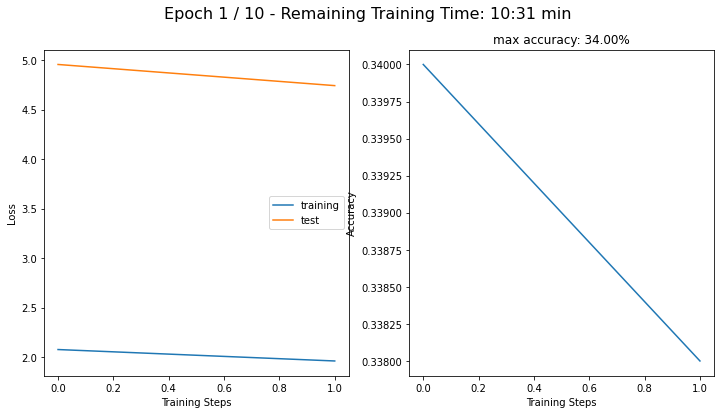

Epoch: __ 2
|||

In [ ]:
import time
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.001
running_average_factor = 0.95

# Initialize the model.
model = LSTM()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
categorical_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))
    #training (and checking in with training)
    start = time.perf_counter()
    running_average = 0
    for (input,target) in dataset:
        print("|", end= "")
        train_loss = train_step(model, input, target, categorical_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, dataset, categorical_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    end = time.perf_counter()
    plot_performance(num_epochs, train_losses, test_losses, test_accuracies, (start, end))